# Hierarchical RAG System

Bu notebook, Project Gutenberg'den "The Children of the New Forest" kitabını kullanarak hiyerarşik parçalama yöntemiyle bir RAG (Retrieval-Augmented Generation) sistemi oluşturur.

**Proje Detayları:**
- **Kitap:** The Children of the New Forest by Frederick Marryat
- **Release:** May 21, 2007
- **Dataset:** NarrativeQA
- **Chunking:** LlamaIndex HierarchicalNodeParser
- **Vector DB:** Milvus Lite
- **Embedding Model:** BAAI/bge-large-en-v1.5 (1024 dim)
- **Retrieval:** AutoMergingRetriever (parent-child hierarchy)
- **LLM:** google/gemma-3-1b-it
- **Metrikler:** BLEU, ROUGE-1, ROUGE-2, ROUGE-L

---
## 1. Kurulum ve Hazırlık

### 1.1 Kütüphaneleri Yükle

In [1]:
# Git clone ve requirements
import os
import sys

# Google Colab için
if 'google.colab' in sys.modules:
    # Repo'yu klonla veya güncelle
    if not os.path.exists('V-RAG-Final'):
        !git clone https://github.com/sendayildirim/V-RAG-Final
    else:
        %cd V-RAG-Final
        !git pull
        %cd ..

    %cd V-RAG-Final

    # Tüm requirements'ı
    !pip install -q -r requirements.txt

    sys.path.append('/content/V-RAG-Final/src')
else:
    # Local için
    sys.path.append('/Users/senda.yildirim/Desktop/V-RAG-Final/src')
    print("Local environment - requirements.txt'i manuel yükleyin: pip install -r requirements.txt")

print("Kütüphaneler yüklendi!")

Cloning into 'V-RAG-Final'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 29 (delta 7), reused 21 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 154.28 KiB | 352.00 KiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/V-RAG-Final
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 146.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### 1.2 Gerekli Modülleri İçe Aktar

In [2]:
from data_loader import DataLoader
from chunker_v2 import HierarchicalChunker
from vector_store_v2 import VectorStore
from rag_pipeline_v2 import RAGPipeline
from baseline_model_v2 import BaselineModel
from metrics import MetricsEvaluator
from experiment_runner_v2 import ExperimentRunner

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch


print("Modüller yüklendi!")
print(f"GPU kullanılabilme durumu: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Modüller yüklendi!
GPU kullanılabilme durumu: True
GPU: NVIDIA A100-SXM4-80GB


### 1.3 Hugging Face Login (Gemma-3 için)

In [3]:
from huggingface_hub import login
login(new_session=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


---
## 2. Veri Hazırlama

### 2.1 Kitap ve Soruları İndir

In [4]:
loader = DataLoader(data_dir="data")
data_paths = loader.load_all_data()

print("\nİndirilen dosyalar:")
print(f"  Book: {data_paths['book']}")
print(f"  Test: {data_paths['test']}")

Book saved at data/children_of_new_forest.txt
Total 39 questions found
Test: 39
Questions saved
  Test: data/questions_test.csv

İndirilen dosyalar:
  Book: data/children_of_new_forest.txt
  Test: data/questions_test.csv


### 2.2 Test Verilerini Yükle

In [5]:
test_df = pd.read_csv(data_paths['test'])

print(f"Toplam test sorusu: {len(test_df)}")
print("\nİlk 3 soru:")
test_df[['question', 'answer1', 'answer2']].head(3)

Toplam test sorusu: 39

İlk 3 soru:


,question,answer1,answer2
0,What is the title of this story?,The Children of the New Forest,The Childeren of the New Forest.
1,"Who saves the 4 orphans; Edward, Humphrey, Ali...",Jacob Armitage,Jacob Armitage
2,Where did Jacob hide the 4 orphans?,In his isolated cottage,In his cottage


---
## 3. Hiyerarşik Chunking (LlamaIndex)

### 3.1 HierarchicalNodeParser ile Chunking

In [6]:
with open(data_paths['book'], 'r', encoding='utf-8') as f:
    book_text = f.read()

print(f"Kitap uzunluğu: {len(book_text)} karakter")

chunker = HierarchicalChunker(
    parent_size=2048,
    child_size=512,
    chunk_overlap=100
)

nodes, node_mapping = chunker.chunk_text(book_text)

stats = chunker.get_chunk_stats(nodes)
print("\nNode İstatistikleri:")
for key, value in stats.items():
    if isinstance(value, dict):
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {value:.1f}" if isinstance(value, float) else f"  {key}: {value}")

Kitap uzunluğu: 631926 karakter
Total 20 chapters
Total 89 parent nodes created
Total 410 child (leaf) nodes created
Total 499 nodes
Chunk overlap: 100 characters

Node İstatistikleri:
  total_nodes: 499
  total_parents: 89
  total_children: 410
  avg_parent_length: 7094.5
  avg_child_length: 1792.3
  max_child_length: 2089
  min_child_length: 281
  num_chapters: 20
  children_per_chapter: {1: 11, 2: 14, 3: 13, 4: 13, 5: 16, 6: 12, 7: 11, 8: 11, 9: 22, 10: 10, 11: 20, 12: 17, 13: 16, 14: 18, 15: 18, 16: 16, 17: 18, 18: 17, 19: 13, 20: 124}
  chunk_overlap: 100


### 3.2 Node Yapısını İncele

In [7]:
from llama_index.core.node_parser import get_leaf_nodes

leaf_nodes = get_leaf_nodes(nodes)

sample_child = leaf_nodes[0]
print("Örnek Child Node:")
print(f"  Node ID: {sample_child.node_id}")
print(f"  Chapter: {sample_child.metadata.get('chapter')}")
print(f"  Chapter Title: {sample_child.metadata.get('chapter_title')}")
print(f"  Text uzunluğu: {len(sample_child.text)} karakter")
print(f"  Text (ilk 200 karakter): {sample_child.text[:200]}...")

if hasattr(sample_child, 'parent_node') and sample_child.parent_node:
    parent_id = sample_child.parent_node.node_id
    print(f"\n  Parent Node ID: {parent_id}")

    if parent_id in node_mapping:
        parent_node = node_mapping[parent_id]
        print(f"  Parent text uzunluğu: {len(parent_node.text)} karakter")
        print(f"  Parent text (ilk 100 karakter): {parent_node.text[:100]}...")
    else:
        print(f"  Parent node mapping'de bulunamadı")

Örnek Child Node:
  Node ID: 7e82b47b-2d83-4ce3-a5bc-433097765897
  Chapter: 1
  Chapter Title: CHAPTER ONE
  Text uzunluğu: 1932 karakter
  Text (ilk 200 karakter): The circumstances which I am about to relate to my juvenile readers took
place in the year 1647. By referring to the history of England of that
date they will find that King Charles the First, against...

  Parent Node ID: 1ae4f6f3-f6c6-40fc-a847-01ed824a78fc
  Parent text uzunluğu: 8164 karakter
  Parent text (ilk 100 karakter): The circumstances which I am about to relate to my juvenile readers took
place in the year 1647. By ...


---
## 4. Vector Store (Milvus + bge-large)

### 4.1 Milvus Vector Store Oluştur

In [8]:
vector_store = VectorStore(
    db_path="./milvus_rag.db",
    model_name="BAAI/bge-large-en-v1.5"
)

print(f"Embedding boyutu: {vector_store.embedding_dim}")

Loading embedding model BAAI/bge-large-en-v1.5


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/milvus_lite/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


New docstore created at ./docstore
Embedding boyutu: 1024


### 4.2 Node'ları İndeksle

In [9]:
import time

start = time.time()
vector_store.create_index(nodes, node_mapping)
indexing_time = time.time() - start

print(f"\nToplam indexing süresi: {indexing_time:.2f}s")

stats = vector_store.get_stats()
print(f"\nVector Store Stats:")
for key, value in stats.items():
    print(f"  {key}: {value}")

Indexing 499 nodes
All nodes added to docstore


Generating embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted

Toplam indexing süresi: 12.57s

Vector Store Stats:
  total_nodes: 499
  leaf_nodes: 410
  parent_nodes: 89
  collection_name: book_chunks
  embedding_dim: 1024
  model: BAAI/bge-large-en-v1.5
  db_path: ./milvus_rag.db


### 4.3 AutoMergingRetriever Testi

In [10]:
test_query = "What is the title of this story?"

_, results = vector_store.hybrid_search(
    query=test_query,
    top_parents=3
)

print(f"Test sorusu: {test_query}")
print(f"\nAutoMerging sonuçları ({len(results)} node):")
for i, result in enumerate(results, 1):
    node_type = "PARENT" if result.get('is_parent', False) else "CHILD"
    print(f"\n{i}. {node_type} (Chapter {result['chapter']}, Score: {result['score']:.4f})")
    print(f"   Text: {result['text'][:150]}...")

AutoMergingRetriever created (hierarchical retrieval)
Test sorusu: What is the title of this story?

AutoMerging sonuçları (9 node):

1. CHILD (Chapter 2, Score: 0.6730)
   Text: "You may be sure of that; no man would hurt babies," replied Jacob.
"The troopers will take them with them to Lymington, I suppose. I've no
fear for t...

2. CHILD (Chapter 3, Score: 0.6729)
   Text: The next morning, as soon as Jacob had given the children their
breakfast, he set off towards Arnwood. He knew that Benjamin had stated
his intention ...

3. PARENT (Chapter 7, Score: 0.6710)
   Text: Humphrey was now after something else. He had made several traps, and
brought in rabbits and hares almost every day. He had also made some
bird traps,...

4. CHILD (Chapter 20, Score: 0.6709)
   Text: Do you fire another gun, as a signal, through the
hole in the front door."

Humphrey stood within four feet of the back door, and fired just above
whe...

5. CHILD (Chapter 2, Score: 0.6707)
   Text: He knocked at the c

---
## 5. Baseline Model (RAG'sız)

### 5.1 Baseline Model Oluştur

In [11]:
baseline = BaselineModel(model_name="google/gemma-3-1b-it")

Device: cuda
Loading baseline model: google/gemma-3-1b-it


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Baseline model loaded


### 5.2 Baseline ile Test Soruları

In [12]:
from performance_monitor import PeakMemoryMonitor
import time

questions = test_df['question'].tolist()

baseline_monitor = PeakMemoryMonitor()
baseline_monitor.record()

print("Baseline model ile sorular cevaplanıyor...")

start_time = time.time()
baseline_results = baseline.batch_answer_questions(
    questions,
    max_new_tokens=100,
    memory_monitor=baseline_monitor
)
baseline_inference_time = time.time() - start_time

baseline_memory_snapshot = baseline_monitor.record()
baseline_memory_summary = baseline_monitor.summary()
baseline_memory_used = baseline_memory_summary['memory_used_mb']
baseline_initial_memory = baseline_memory_summary['initial_memory_mb']
baseline_peak_memory = baseline_memory_summary['peak_memory_mb']
baseline_end_memory = baseline_memory_snapshot.current_mb

print(f"{len(baseline_results)} soru cevaplandı!")

# Metrics
print("" + "="*60)
print("BASELINE MODEL PERFORMANS METRİKLERİ")
print("="*60)
print(f"Toplam Inference Time: {baseline_inference_time:.2f} saniye")
print(f"Ortalama Soru Başı Süre: {baseline_inference_time/len(questions):.2f} saniye")
print(f"Memory Kullanımı (Peak - Initial): {baseline_memory_used:.2f} MB")
print(f"Başlangıç Memory: {baseline_initial_memory:.2f} MB")
print(f"Peak Memory: {baseline_peak_memory:.2f} MB")
print(f"Bitiş Memory: {baseline_end_memory:.2f} MB")
print("="*60)

print("Örnek Baseline Cevaplar:")
for i, result in enumerate(baseline_results[:3], 1):
    print(f"{i}. Soru: {result['question']}")
    print(f"   Cevap: {result['answer']}")


Baseline model ile sorular cevaplanıyor...

Answering question 1/39

Answering question 2/39

Answering question 3/39

Answering question 4/39

Answering question 5/39

Answering question 6/39

Answering question 7/39

Answering question 8/39

Answering question 9/39

Answering question 10/39

Answering question 11/39

Answering question 12/39

Answering question 13/39

Answering question 14/39

Answering question 15/39

Answering question 16/39

Answering question 17/39

Answering question 18/39

Answering question 19/39

Answering question 20/39

Answering question 21/39

Answering question 22/39

Answering question 23/39

Answering question 24/39

Answering question 25/39

Answering question 26/39

Answering question 27/39

Answering question 28/39

Answering question 29/39

Answering question 30/39

Answering question 31/39

Answering question 32/39

Answering question 33/39

Answering question 34/39

Answering question 35/39

Answering question 36/39

Answering question 37/39

Ans

In [13]:
baseline_df = pd.DataFrame(baseline_results)
os.makedirs("results", exist_ok=True)
baseline_df.to_csv("results/baseline_QA.csv", index=False)
print("Baseline sonuçları kaydedildi: results/baseline_QA.csv")

Baseline sonuçları kaydedildi: results/baseline_QA.csv


---
## 6. RAG Pipeline (AutoMergingRetriever)

### 6.1 RAG Pipeline Oluştur

In [14]:
rag_pipeline = RAGPipeline(
    vector_store=vector_store,
    model_name="google/gemma-3-1b-it",
    temperature=0.5
)

Device: cuda
Model loaded


### 6.2 RAG ile Test Soruları

In [15]:
from performance_monitor import PeakMemoryMonitor
import time

rag_monitor = PeakMemoryMonitor()
rag_monitor.record()

print("RAG pipeline ile sorular cevaplanıyor...")

start_time = time.time()
rag_results = rag_pipeline.batch_answer_questions(
    questions,
    top_k=3,
    max_new_tokens=100,
    memory_monitor=rag_monitor
)
rag_inference_time = time.time() - start_time

rag_memory_snapshot = rag_monitor.record()
rag_memory_summary = rag_monitor.summary()
rag_memory_used = rag_memory_summary['memory_used_mb']
rag_initial_memory = rag_memory_summary['initial_memory_mb']
rag_peak_memory = rag_memory_summary['peak_memory_mb']
rag_end_memory = rag_memory_snapshot.current_mb

print(f"{len(rag_results)} soru cevaplandı!")

# Metrics
print("="*60)
print("RAG PIPELINE PERFORMANS METRİKLERİ")
print("="*60)
print(f"Toplam Inference Time: {rag_inference_time:.2f} saniye")
print(f"Ortalama Soru Başı Süre: {rag_inference_time/len(questions):.2f} saniye")
print(f"Memory Kullanımı (Peak - Initial): {rag_memory_used:.2f} MB")
print(f"Başlangıç Memory: {rag_initial_memory:.2f} MB")
print(f"Peak Memory: {rag_peak_memory:.2f} MB")
print(f"Bitiş Memory: {rag_end_memory:.2f} MB")
print("="*60)

print("Örnek RAG Cevaplar:")
for i, result in enumerate(rag_results[:3], 1):
    print(f"{i}. Soru: {result['question']}")
    print(f"   Cevap: {result['answer']}")
    print(f"   Context (ilk 100 karakter): {result['context'][:100]}...")


RAG pipeline ile sorular cevaplanıyor...

Answering question 1/39

Answering question 2/39

Answering question 3/39
> Merging 3 nodes into parent node.
> Parent node id: 70d40169-1a9f-48fe-a0ae-b72e37dc00ea.
> Parent node text: The old forester lay awake the whole of this night, reflecting how he
should act relative to the ...


Answering question 4/39

Answering question 5/39
> Merging 1 nodes into parent node.
> Parent node id: 5bd0895c-0fc3-44e2-99b6-b691ee14f602.
> Parent node text: He had been about eight miles from
Arnwood when he had concealed himself in the fern. Jacob first...


Answering question 6/39

Answering question 7/39

Answering question 8/39

Answering question 9/39

Answering question 10/39

Answering question 11/39
> Merging 1 nodes into parent node.
> Parent node id: 5bd0895c-0fc3-44e2-99b6-b691ee14f602.
> Parent node text: He had been about eight miles from
Arnwood when he had concealed himself in the fern. Jacob first...


Answering question 12/39

Answering que

In [16]:
rag_results_df = pd.DataFrame(rag_results)
rag_results_df
rag_results_df.to_csv("results/RAG_QA.csv", index=False)


### 6.3 Performans Metrikleri Karşılaştırması


PERFORMANS METRİKLERİ KARŞILAŞTIRMASI (RAG vs BASELINE)
       Model Toplam Inference Time (s) Avg Time per Question (s) Memory Usage (MB)
RAG Pipeline                     60.95                      1.56              2.76
    Baseline                     44.89                      1.15            413.30


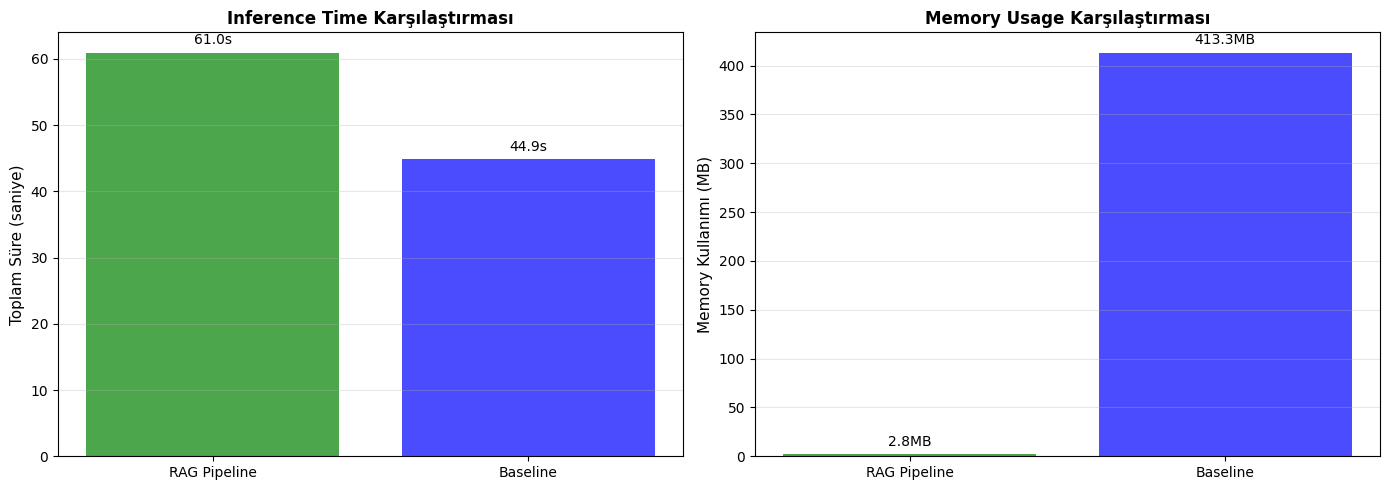


Grafik kaydedildi: results/performance_comparison.png


In [17]:
try:
    baseline_inference = globals().get('baseline_inference_time', 'N/A')
    baseline_mem = globals().get('baseline_memory_used', 'N/A')
    rag_inference = globals().get('rag_inference_time', 'N/A')
    rag_mem = globals().get('rag_memory_used', 'N/A')

    perf_comparison = pd.DataFrame({
        'Model': ['RAG Pipeline', 'Baseline'],
        'Toplam Inference Time (s)': [
            f"{rag_inference:.2f}" if isinstance(rag_inference, (int, float)) else rag_inference,
            f"{baseline_inference:.2f}" if isinstance(baseline_inference, (int, float)) else baseline_inference
        ],
        'Avg Time per Question (s)': [
            f"{rag_inference/len(questions):.2f}" if isinstance(rag_inference, (int, float)) else 'N/A',
            f"{baseline_inference/len(questions):.2f}" if isinstance(baseline_inference, (int, float)) else 'N/A'
        ],
        'Memory Usage (MB)': [
            f"{rag_mem:.2f}" if isinstance(rag_mem, (int, float)) else rag_mem,
            f"{baseline_mem:.2f}" if isinstance(baseline_mem, (int, float)) else baseline_mem
        ]
    })

    print("\n" + "="*80)
    print("PERFORMANS METRİKLERİ KARŞILAŞTIRMASI (RAG vs BASELINE)")
    print("="*80)
    print(perf_comparison.to_string(index=False))
    print("="*80)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    models = ['RAG Pipeline', 'Baseline']

    inference_times = [
        rag_inference if isinstance(rag_inference, (int, float)) else 0,
        baseline_inference if isinstance(baseline_inference, (int, float)) else 0
    ]
    memory_usage = [
        rag_mem if isinstance(rag_mem, (int, float)) else 0,
        baseline_mem if isinstance(baseline_mem, (int, float)) else 0
    ]

    # Inference Time
    axes[0].bar(models, inference_times, color=['green', 'blue'], alpha=0.7)
    axes[0].set_ylabel('Toplam Süre (saniye)', fontsize=11)
    axes[0].set_title('Inference Time Karşılaştırması', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

    for i, (model, time) in enumerate(zip(models, inference_times)):
        axes[0].text(i, time + max(inference_times)*0.02, f"{time:.1f}s", ha='center', fontsize=10)

    # Memory Usage
    axes[1].bar(models, memory_usage, color=['green', 'blue'], alpha=0.7)
    axes[1].set_ylabel('Memory Kullanımı (MB)', fontsize=11)
    axes[1].set_title('Memory Usage Karşılaştırması', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)

    for i, (model, mem) in enumerate(zip(models, memory_usage)):
        axes[1].text(i, mem + abs(max(memory_usage, key=abs))*0.02, f"{mem:.1f}MB", ha='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('results/performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nGrafik kaydedildi: results/performance_comparison.png")

except NameError as e:
    print(f"UYARI: Bazı değişkenler tanımlı değil. Lütfen önce cell-29 ve cell-35'i çalıştırın.")
    print(f"Hata: {e}")

---
## 7. Performans Değerlendirme

### 7.1 BLEU ve ROUGE Metrikleri

In [18]:
evaluator = MetricsEvaluator()

comparison = evaluator.compare_models(
    rag_results=rag_results,
    baseline_results=baseline_results,
    ground_truth=test_df
)

evaluator.print_comparison(comparison)

evaluator.save_results(comparison, "results/rag_vs_baseline.json")

Calculating RAG metrics
Calculating baseline metrics
Model Comparison Results:

RAG System:
  BLEU:    1.61
  ROUGE-1: 14.44
  ROUGE-2: 3.88
  ROUGE-L: 13.93

Baseline (without RAG):
  BLEU:    1.57
  ROUGE-1: 7.00
  ROUGE-2: 2.76
  ROUGE-L: 6.78

Improvement (RAG - Baseline):
  BLEU:    +0.03
  ROUGE-1: +7.44
  ROUGE-2: +1.12
  ROUGE-L: +7.14

Results saved at results/rag_vs_baseline.json


### 7.2 Sonuçları Görselleştir

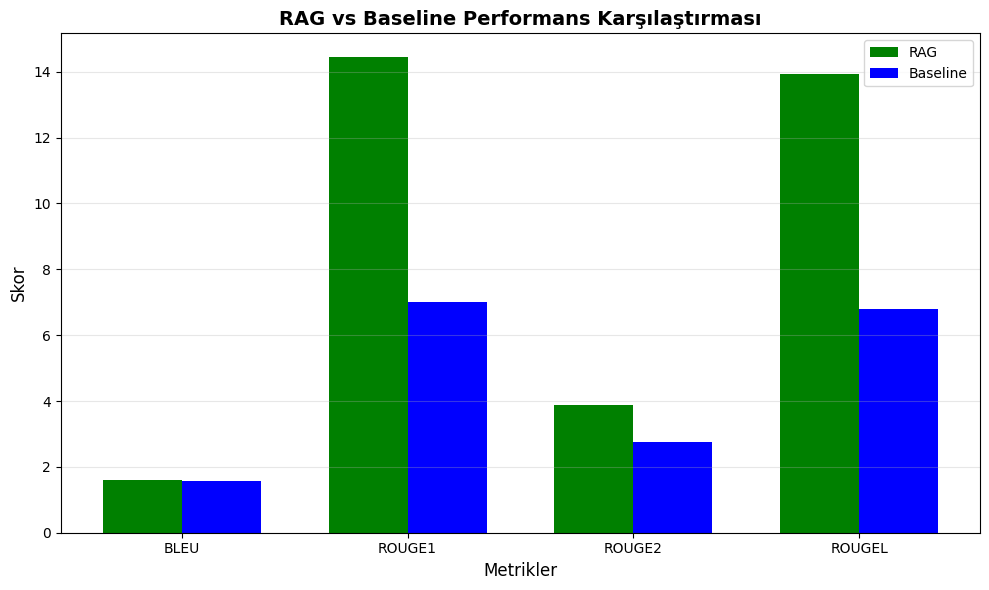

Grafik kaydedildi: results/rag_vs_baseline.png


In [19]:
metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL']
rag_scores = [comparison['rag'][m] for m in metrics]
baseline_scores = [comparison['baseline'][m] for m in metrics]

x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - width/2 for i in x], rag_scores, width, label='RAG', color='green')
ax.bar([i + width/2 for i in x], baseline_scores, width, label='Baseline', color='blue')

ax.set_xlabel('Metrikler', fontsize=12)
ax.set_ylabel('Skor', fontsize=12)
ax.set_title('RAG vs Baseline Performans Karşılaştırması', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in metrics])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/rag_vs_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafik kaydedildi: results/rag_vs_baseline.png")

---
## 8. Hiperparametre Optimizasyonu

### 8.1 Grid Search Parametreleri

In [20]:
##NOT BU KISIMDA 2 WORKER'LI PARALLEL RUN ÇALISIYOR. T4 MAKİNEDE ZORLANDI VE HATA ALDI, A100 İLE DEVAM ETMEM GEREKTİ. RESTART EDIP A100 ile devam ettim.

PARENT_SIZES = [2048, 4096]
CHILD_SIZES = [512, 1024]
TEMPERATURES = [0.1, 0.3]
CHUNK_OVERLAPS = [0, 100, 200]

runner = ExperimentRunner(
    book_path=data_paths['book'],
    test_questions_path=data_paths['test'],
    results_dir="results/experiments_v2"
)

print("Grid search başlatılıyor...")
print(f"Toplam index oluşturma: {len(PARENT_SIZES) * len(CHILD_SIZES) * len(CHUNK_OVERLAPS)} kere")
print(f"Toplam deney sayısı: {len(PARENT_SIZES) * len(CHILD_SIZES) * len(TEMPERATURES) * len(CHUNK_OVERLAPS)} deney")
print("\nNOT: Her index bir kere oluşturulup farklı temperature'lerle test edilecek")

all_results = runner.run_grid_search(
    parent_sizes=PARENT_SIZES,
    child_sizes=CHILD_SIZES,
    temperatures=TEMPERATURES,
    chunk_overlaps=CHUNK_OVERLAPS
)

runner.save_summary(all_results, summary_filename="experiment_summary_v2")

Grid search başlatılıyor...
Toplam index oluşturma: 12 kere
Toplam deney sayısı: 24 deney

NOT: Her index bir kere oluşturulup farklı temperature'lerle test edilecek
CREATING INDEX: parent=2048, child=512, overlap=0
Total 20 chapters
Total 84 parent nodes created
Total 381 child (leaf) nodes created
Total 465 nodes
Chunk overlap: 0 characters
  Chunking completed: 0.97s
Loading embedding model BAAI/bge-large-en-v1.5
Old docstore deleted at ./docstore
New docstore created at ./docstore
Indexing 465 nodes
All nodes added to docstore


Generating embeddings:   0%|          | 0/465 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted
  Indexing completed: 14.89s
OVERALL PROGRESS: 1/24
Testing temperature=0.1
Experiment: parent_size=2048, child_size=512, temperature=0.1, overlap=0
1-2. Using ready index (chunking: 0.97s, indexing: 14.89s)
3. Answering questions (temperature=0.1)...
Device: cuda
Model loaded
AutoMergingRetriever created (hierarchical retrieval)
  Question 1/39 - 1.07s
  Question 2/39 - 1.33s
  Question 3/39 - 1.18s
> Merging 1 nodes into parent node.
> Parent node id: 75dafbeb-97e1-4445-a568-ce72545ce0b2.
> Parent node text: "I cannot say; I fear that I shall not be able very soon to look in his
injured face, and it will...

  Question 4/39 - 0.39s
  Question 5/39 - 1.10s
  Question 6/39 - 2.00s
  Question 7/39 - 1.08s
> Merging 3 nodes into parent node.
> Parent node id: 8cdbfea2-1da6-4ecf-ade3-ebdddaa390e3.
> Parent node text: Edward put the pony to a trot, and in two hours was on the other side of
the New Forest. The

Generating embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted
  Indexing completed: 15.69s
OVERALL PROGRESS: 3/24
Testing temperature=0.1
Experiment: parent_size=2048, child_size=512, temperature=0.1, overlap=100
1-2. Using ready index (chunking: 0.93s, indexing: 15.69s)
3. Answering questions (temperature=0.1)...
Device: cuda
Model loaded
AutoMergingRetriever created (hierarchical retrieval)
  Question 1/39 - 1.05s
  Question 2/39 - 0.79s
> Merging 3 nodes into parent node.
> Parent node id: 9e686d7a-4747-4f76-925a-5b6c461ef001.
> Parent node text: The old forester lay awake the whole of this night, reflecting how he
should act relative to the ...

  Question 3/39 - 0.98s
  Question 4/39 - 0.47s
> Merging 1 nodes into parent node.
> Parent node id: 5c5021c0-f720-4f70-b4de-4ab8e362cef9.
> Parent node text: He had been about eight miles from
Arnwood when he had concealed himself in the fern. Jacob first...

  Question 5/39 - 1.00s
  Question 6/39 - 1.73s
  Question 7

Generating embeddings:   0%|          | 0/652 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted
  Indexing completed: 18.42s
OVERALL PROGRESS: 5/24
Testing temperature=0.1
Experiment: parent_size=2048, child_size=512, temperature=0.1, overlap=200
1-2. Using ready index (chunking: 1.11s, indexing: 18.42s)
3. Answering questions (temperature=0.1)...
Device: cuda
Model loaded
AutoMergingRetriever created (hierarchical retrieval)
  Question 1/39 - 1.03s
  Question 2/39 - 0.82s
> Merging 4 nodes into parent node.
> Parent node id: 31f3ac23-2015-4fd0-bfad-7c64430a2507.
> Parent node text: The old forester lay awake the whole of this night, reflecting how he
should act relative to the ...

  Question 3/39 - 1.85s
  Question 4/39 - 5.60s
  Question 5/39 - 1.07s
> Merging 1 nodes into parent node.
> Parent node id: 3b987bb3-0cce-4f92-9be5-90957073712c.
> Parent node text: "You live here?"

"For the present, good sir; and now I leave you."

"That's a nice little girl,"...

  Question 6/39 - 1.96s
  Question 7

Generating embeddings:   0%|          | 0/298 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted
  Indexing completed: 11.44s
OVERALL PROGRESS: 7/24
Testing temperature=0.1
Experiment: parent_size=2048, child_size=1024, temperature=0.1, overlap=0
1-2. Using ready index (chunking: 0.77s, indexing: 11.44s)
3. Answering questions (temperature=0.1)...
Device: cuda
Model loaded
AutoMergingRetriever created (hierarchical retrieval)
  Question 1/39 - 0.76s
  Question 2/39 - 0.70s
> Merging 2 nodes into parent node.
> Parent node id: 60473143-6cbc-4dd9-8b8c-2e46ef97b6c7.
> Parent node text: When about three
hundred yards from the game, Jacob again sank down on his hands and
knees, crawl...

> Merging 2 nodes into parent node.
> Parent node id: 63759937-a440-434d-af81-1fbb6ab88bfa.
> Parent node text: The old forester lay awake the whole of this night, reflecting how he
should act relative to the ...

  Question 3/39 - 1.50s
> Merging 1 nodes into parent node.
> Parent node id: 81a1f37e-3b2c-4b6c-8650-2e6022c

Generating embeddings:   0%|          | 0/325 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted
  Indexing completed: 12.23s
OVERALL PROGRESS: 9/24
Testing temperature=0.1
Experiment: parent_size=2048, child_size=1024, temperature=0.1, overlap=100
1-2. Using ready index (chunking: 0.81s, indexing: 12.23s)
3. Answering questions (temperature=0.1)...
Device: cuda
Model loaded
AutoMergingRetriever created (hierarchical retrieval)
> Merging 2 nodes into parent node.
> Parent node id: 2187558b-e1a3-42f1-9f51-cdcf7195fde3.
> Parent node text: "You may be sure of that; no man would hurt babies," replied Jacob.
"The troopers will take them ...

  Question 1/39 - 1.10s
> Merging 1 nodes into parent node.
> Parent node id: e4b24cdd-564b-468f-8f13-984a3d1b4aa5.
> Parent node text: Humphrey at last said to Alice, "You hurt poor Edward's
arm--you don't know how painful it is! Co...

  Question 2/39 - 0.82s
> Merging 2 nodes into parent node.
> Parent node id: 5a8b0049-5f86-4d25-b8b9-9098374a5bc3.
> Parent node t

Generating embeddings:   0%|          | 0/342 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted
  Indexing completed: 12.44s
OVERALL PROGRESS: 11/24
Testing temperature=0.1
Experiment: parent_size=2048, child_size=1024, temperature=0.1, overlap=200
1-2. Using ready index (chunking: 0.83s, indexing: 12.44s)
3. Answering questions (temperature=0.1)...
Device: cuda
Model loaded
AutoMergingRetriever created (hierarchical retrieval)
> Merging 2 nodes into parent node.
> Parent node id: 12d7680a-07a5-4b1b-acf8-f4127683a388.
> Parent node text: The next morning, as soon as Jacob had given the children their
breakfast, he set off towards Arn...

  Question 1/39 - 1.11s
  Question 2/39 - 5.75s
> Merging 3 nodes into parent node.
> Parent node id: 1e51b7ad-dff2-4dd5-bc1a-09be1825d9c7.
> Parent node text: The old forester lay awake the whole of this night, reflecting how he
should act relative to the ...

  Question 3/39 - 1.99s
  Question 4/39 - 0.84s
  Question 5/39 - 1.25s
> Merging 1 nodes into parent node

Generating embeddings:   0%|          | 0/388 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted
  Indexing completed: 13.06s
OVERALL PROGRESS: 13/24
Testing temperature=0.1
Experiment: parent_size=4096, child_size=512, temperature=0.1, overlap=0
1-2. Using ready index (chunking: 0.82s, indexing: 13.06s)
3. Answering questions (temperature=0.1)...
Device: cuda
Model loaded
AutoMergingRetriever created (hierarchical retrieval)
  Question 1/39 - 1.24s
  Question 2/39 - 0.92s
> Merging 5 nodes into parent node.
> Parent node id: da856390-60c7-41be-a046-a93292ac3258.
> Parent node text: The old forester lay awake the whole of this night, reflecting how he
should act relative to the ...

  Question 3/39 - 3.27s
  Question 4/39 - 2.56s
  Question 5/39 - 1.14s
  Question 6/39 - 3.48s
  Question 7/39 - 2.40s
  Question 8/39 - 1.60s
  Question 9/39 - 1.18s
  Question 10/39 - 3.83s
  Question 11/39 - 1.00s
  Question 12/39 - 1.78s
  Question 13/39 - 2.02s
  Question 14/39 - 1.14s
  Question 15/39 - 0.65s
  Que

Generating embeddings:   0%|          | 0/452 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted
  Indexing completed: 14.39s
OVERALL PROGRESS: 15/24
Testing temperature=0.1
Experiment: parent_size=4096, child_size=512, temperature=0.1, overlap=100
1-2. Using ready index (chunking: 0.89s, indexing: 14.39s)
3. Answering questions (temperature=0.1)...
Device: cuda
Model loaded
AutoMergingRetriever created (hierarchical retrieval)
  Question 1/39 - 1.08s
  Question 2/39 - 2.50s
  Question 3/39 - 2.07s
  Question 4/39 - 1.02s
  Question 5/39 - 1.14s
  Question 6/39 - 4.31s
  Question 7/39 - 0.99s
  Question 8/39 - 1.68s
  Question 9/39 - 1.19s
  Question 10/39 - 1.28s
  Question 11/39 - 0.27s
  Question 12/39 - 0.98s
  Question 13/39 - 0.97s
  Question 14/39 - 1.00s
  Question 15/39 - 0.82s
  Question 16/39 - 2.82s
  Question 17/39 - 2.69s
  Question 18/39 - 0.77s
  Question 19/39 - 3.15s
  Question 20/39 - 1.20s
  Question 21/39 - 1.40s
  Question 22/39 - 1.29s
  Question 23/39 - 0.88s
  Question 24/39 

Generating embeddings:   0%|          | 0/580 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted
  Indexing completed: 17.52s
OVERALL PROGRESS: 17/24
Testing temperature=0.1
Experiment: parent_size=4096, child_size=512, temperature=0.1, overlap=200
1-2. Using ready index (chunking: 1.00s, indexing: 17.52s)
3. Answering questions (temperature=0.1)...
Device: cuda
Model loaded
AutoMergingRetriever created (hierarchical retrieval)
  Question 1/39 - 1.22s
  Question 2/39 - 0.80s
  Question 3/39 - 1.10s
  Question 4/39 - 3.69s
  Question 5/39 - 1.18s
  Question 6/39 - 2.58s
  Question 7/39 - 0.62s
  Question 8/39 - 3.63s
  Question 9/39 - 1.32s
  Question 10/39 - 2.28s
  Question 11/39 - 1.14s
  Question 12/39 - 0.99s
  Question 13/39 - 0.79s
  Question 14/39 - 0.80s
  Question 15/39 - 0.65s
  Question 16/39 - 0.96s
  Question 17/39 - 3.56s
  Question 18/39 - 0.92s
  Question 19/39 - 2.37s
  Question 20/39 - 1.37s
> Merging 2 nodes into parent node.
> Parent node id: 43283289-5d16-4bbe-8081-c3b98de64ed8.


Generating embeddings:   0%|          | 0/234 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted
  Indexing completed: 9.95s
OVERALL PROGRESS: 19/24
Testing temperature=0.1
Experiment: parent_size=4096, child_size=1024, temperature=0.1, overlap=0
1-2. Using ready index (chunking: 0.71s, indexing: 9.95s)
3. Answering questions (temperature=0.1)...
Device: cuda
Model loaded
AutoMergingRetriever created (hierarchical retrieval)
  Question 1/39 - 1.86s
  Question 2/39 - 0.76s
> Merging 4 nodes into parent node.
> Parent node id: 79d4ecbb-c2c9-4341-bdd8-aa6e2a6c9ee5.
> Parent node text: The old forester lay awake the whole of this night, reflecting how he
should act relative to the ...

  Question 3/39 - 3.47s
  Question 4/39 - 2.25s
> Merging 1 nodes into parent node.
> Parent node id: 18870ea0-9dc5-4b83-b0b3-8135c81ed2ff.
> Parent node text: But there were outhouses belonging to
it: a stall, in which White Billy, the pony, lived during t...

  Question 5/39 - 1.30s
  Question 6/39 - 4.96s
  Question 7/3

Generating embeddings:   0%|          | 0/240 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted
  Indexing completed: 10.38s
OVERALL PROGRESS: 21/24
Testing temperature=0.1
Experiment: parent_size=4096, child_size=1024, temperature=0.1, overlap=100
1-2. Using ready index (chunking: 0.72s, indexing: 10.38s)
3. Answering questions (temperature=0.1)...
Device: cuda
Model loaded
AutoMergingRetriever created (hierarchical retrieval)
  Question 1/39 - 1.47s
  Question 2/39 - 0.78s
> Merging 4 nodes into parent node.
> Parent node id: 2eb56ea8-ee76-4334-9c11-42b39fc7570b.
> Parent node text: The old forester lay awake the whole of this night, reflecting how he
should act relative to the ...

  Question 3/39 - 3.44s
  Question 4/39 - 1.87s
> Merging 1 nodes into parent node.
> Parent node id: c37f385a-6e97-4b2d-8427-97c72fa4b75f.
> Parent node text: As we said before, it contained a
large sitting-room, or kitchen, in which were a spacious hearth...

  Question 5/39 - 1.21s
  Question 6/39 - 2.59s
  Question

Generating embeddings:   0%|          | 0/246 [00:00<?, ?it/s]

Storage context persisted at: ./docstore
Index successfully created and persisted
  Indexing completed: 10.21s
OVERALL PROGRESS: 23/24
Testing temperature=0.1
Experiment: parent_size=4096, child_size=1024, temperature=0.1, overlap=200
1-2. Using ready index (chunking: 0.73s, indexing: 10.21s)
3. Answering questions (temperature=0.1)...
Device: cuda
Model loaded
AutoMergingRetriever created (hierarchical retrieval)
> Merging 2 nodes into parent node.
> Parent node id: 38fe645d-bab6-4165-8d9c-c36a7faebf08.
> Parent node text: "You may be sure of that; no man would hurt babies," replied Jacob.
"The troopers will take them ...

  Question 1/39 - 1.35s
  Question 2/39 - 0.98s
> Merging 3 nodes into parent node.
> Parent node id: a1f7f149-c78b-462e-bafb-a95c36f0c0cd.
> Parent node text: The old forester lay awake the whole of this night, reflecting how he
should act relative to the ...

  Question 3/39 - 3.15s
  Question 4/39 - 2.26s
  Question 5/39 - 1.38s
> Merging 3 nodes into parent node

### 8.2 En İyi Parametreleri Bul

In [21]:
exp_df = pd.read_csv('results/experiments_v2/experiment_summary_v2.csv')

baseline_row = pd.Series({
    'parent_size': 'Baseline',
    'child_size': 'Baseline',
    'temperature': 0.5,
    'chunk_overlap': 0,
    'bleu': comparison['baseline']['bleu'],
    'rouge1': comparison['baseline']['rouge1'],
    'rouge2': comparison['baseline']['rouge2'],
    'rougeL': comparison['baseline']['rougeL'],
    'avg_question_time': f'{baseline_inference_time/len(questions):.2f}',
    'inference_time': f'{baseline_inference_time:.2f}',
    'memory_used_mb': f'{baseline_memory_used:.2f}',
    'total_time': None
})


exp_df_final = pd.concat([exp_df, baseline_row.to_frame().T], ignore_index=True)



/tmp/ipython-input-3110634543.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  exp_df_final = pd.concat([exp_df, baseline_row.to_frame().T], ignore_index=True)


In [22]:
exp_df_final.to_csv("grid_search_results.csv", index=False)
exp_df_final

,parent_size,child_size,temperature,chunk_overlap,total_nodes,parent_nodes,child_nodes,bleu,rouge1,rouge2,rougeL,chunking_time,indexing_time,inference_time,avg_question_time,total_time,db_size_mb,initial_memory_mb,peak_memory_mb,memory_used_mb
0,2048,512,0.1,0,465.0,84.0,381.0,1.428944,14.183269,5.48787,13.967537,0.969440,14.894878,70.725504,1.812969,75.332062,4.300781,10273.085938,12415.474609,2142.388672
1,2048,512,0.3,0,465.0,84.0,381.0,1.077465,12.311713,3.2364,12.213094,0.969440,14.894878,70.589931,1.809489,75.198354,4.300781,10403.253906,12433.431641,2030.177734
2,2048,512,0.1,100,499.0,89.0,410.0,1.666394,12.375364,4.252156,12.187243,0.932894,15.689265,63.147034,1.618626,68.180543,4.617188,10529.765625,12560.677734,2030.912109
3,2048,512,0.3,100,499.0,89.0,410.0,1.74621,14.549974,4.230051,14.264639,0.932894,15.689265,61.346907,1.572461,66.158535,4.617188,10548.707031,12530.580078,1981.873047
4,2048,512,0.1,200,652.0,93.0,559.0,1.980596,16.086638,6.829799,15.848543,1.114003,18.418768,58.373616,1.496231,63.249058,5.871094,10625.132812,12563.193359,1938.060547
5,2048,512,0.3,200,652.0,93.0,559.0,1.770294,15.200062,6.370454,15.013164,1.114003,18.418768,59.428979,1.523283,64.374038,5.871094,10649.097656,12581.123047,1932.025391
6,2048,1024,0.1,0,298.0,84.0,214.0,2.404435,15.328625,5.447289,15.065176,0.772852,11.438024,57.135177,1.464296,61.829378,3.160156,10669.750000,12594.498047,1924.748047
7,2048,1024,0.3,0,298.0,84.0,214.0,1.770856,13.868795,4.329863,13.720826,0.772852,11.438024,60.738506,1.556661,65.367513,3.160156,10015.062500,12131.935547,2116.873047
8,2048,1024,0.1,100,325.0,89.0,236.0,1.720749,12.669695,4.042917,12.504269,0.806305,12.232304,65.770141,1.685751,70.364758,3.457031,10232.472656,12150.943359,1918.470703
9,2048,1024,0.3,100,325.0,89.0,236.0,1.649977,12.007546,4.280897,11.774446,0.806305,12.232304,69.453556,1.780194,74.181646,3.457031,10236.847656,12148.755859,1911.908203


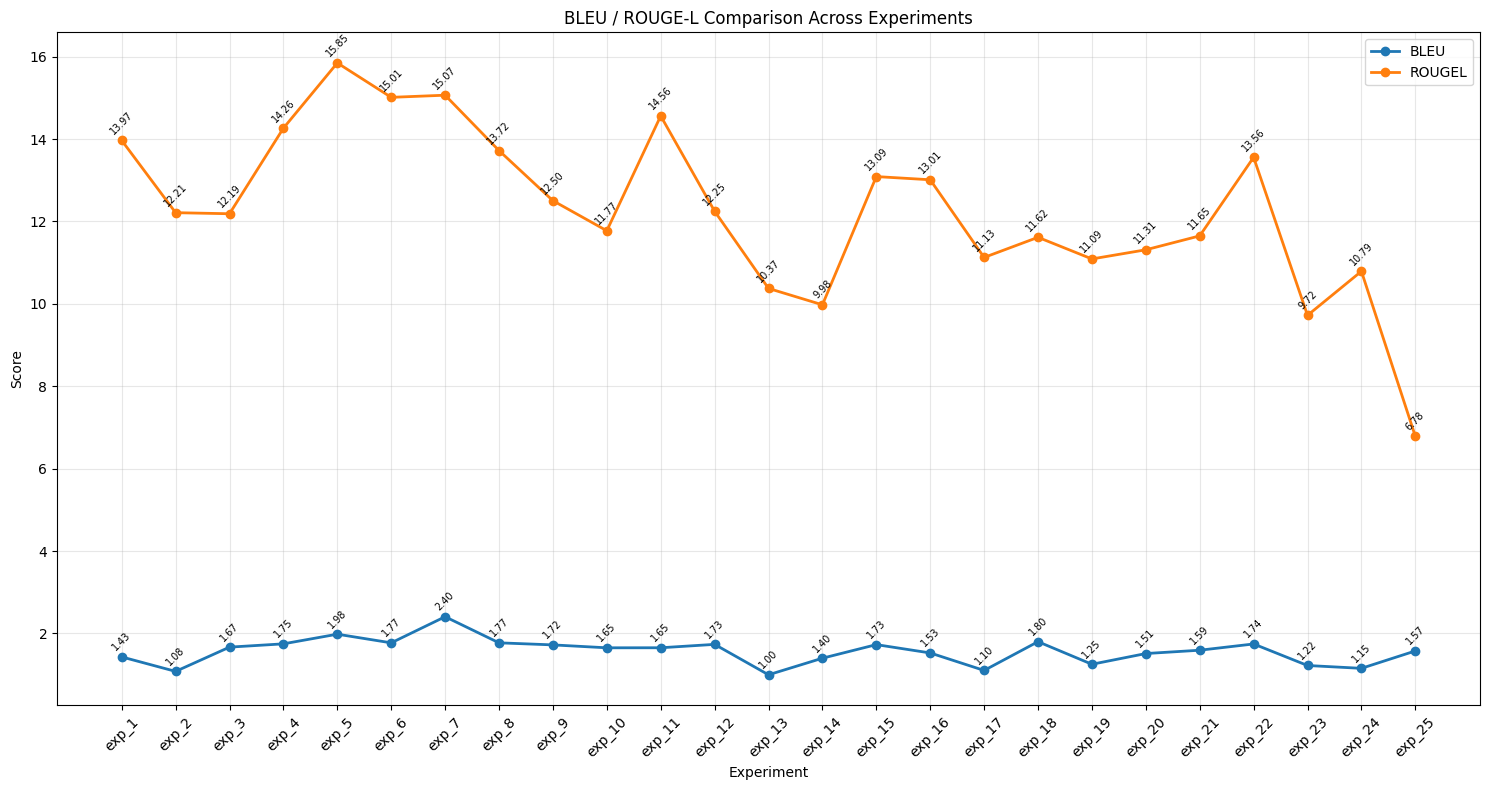

<Figure size 640x480 with 0 Axes>

In [23]:
exp_df_final = exp_df_final.copy()
exp_df_final['experiment_name'] = [f"exp_{i+1}" for i in range(len(exp_df_final))]

import matplotlib.pyplot as plt

metrics = ['bleu', 'rougeL']

plt.figure(figsize=(15,8))

for metric in metrics:
    plt.plot(
        exp_df_final['experiment_name'],
        exp_df_final[metric],
        marker='o',
        linewidth=2,
        label=metric.upper()
    )


    for x, y in zip(exp_df_final['experiment_name'], exp_df_final[metric]):
        plt.text(
            x, y + 0.15,
            f"{y:.2f}",
            fontsize=7,
            rotation=45,
            ha='center'
        )

plt.xlabel("Experiment")
plt.ylabel("Score")
plt.title("BLEU / ROUGE-L Comparison Across Experiments")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.savefig('results/rag_vs_baseline_param_opt.png', dpi=300, bbox_inches='tight')

